In [1]:
import pandas as pd
import numpy as np
import text2emotion as te
import pysentimiento as create_analyzer

import warnings
warnings.filterwarnings('ignore')
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessicaloureiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jessicaloureiro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jessicaloureiro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the two datasets
biden = pd.read_csv("Data/hashtag_joebiden.csv", lineterminator='\n')
trump = pd.read_csv("Data/hashtag_donaldtrump.csv", lineterminator='\n')

In [3]:
biden["president_hashtag"]='joebiden'
trump["president_hashtag"]='donaldtrump'

In [4]:
# Combine them into one dataframe
all_tweets = pd.concat([biden, trump]).drop_duplicates(["tweet_id"]).reset_index(drop = True)

In [5]:
# Select only tweets from the US
df_us_1 = all_tweets[(all_tweets['country'] == 'United States of America')]
df_us_2 = all_tweets[(all_tweets['country'] == 'United States')]
df_us_tweets = pd.concat([df_us_1, df_us_2])

In [6]:
# Select only the useful columns
all_tweets = all_tweets[["created_at",
                "tweet_id",
                "tweet",
                "likes",
                "retweet_count",
                "user_screen_name",
                "user_join_date",
                "user_followers_count",
                "state",
                "president_hashtag"]]

In [7]:
# Define the states for swing, red and blue states
swing = ['Arizona', 'Florida', 'Georgia', 'Iowa', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Texas', 'Wisconsin']
republican = ['Idaho', 'Wyoming', 'North Dakota', 'South Dakota', 'Montana', 'Utah', 'Kansas', 'Oklahoma', 'Alabama', 'Mississippi', 'Louisiana', 'Arkansas', 'Tennessee', 'Kentucky', 'South Carolina', 'Alaska', 'West Virginia', 'Missouri', 'Nebraska']
democrat = ['New York', 'New Jersey', 'Maryland', 'Delaware', 'New England', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'California', 'Oregon', 'Washington', 'Hawaii', 'New Mexico', 'Illinois', 'Colorado', 'Virginia', 'Maine']
all_states = swing + republican + democrat

In [8]:
# To remove states that are not in the US
all_tweets = all_tweets[all_tweets['state'].isin(all_states)]

In [9]:
# create column for dominant party:
# create a list of conditions
conditions = [
    (all_tweets['state'].isin(swing)),
    (all_tweets['state'].isin(republican)),
    (all_tweets['state'].isin(democrat))
    ]

# create a list of the values we want to assign for each condition
values = ['swing', 'republican', 'democrat']

# create a new column and use np.select to assign values to it using our lists as arguments
all_tweets['dominant_party'] = np.select(conditions, values)

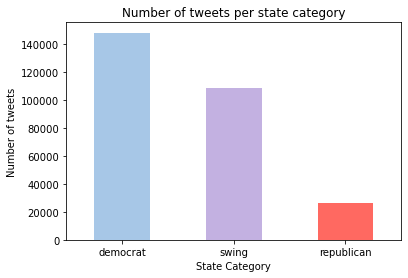

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = all_tweets.dominant_party.value_counts().plot(kind = 'bar',
                                    title="Number of tweets per state category",color=['#A7C7E7', '#C3B1E1', '#ff6961'])
ax.set_xlabel("State Category")
ax.set_ylabel("Number of tweets")
plt.xticks(rotation=0)

fig.savefig('all_tweets_dominant_party.jpg', bbox_inches='tight')

In [11]:
all_tweets.dominant_party.value_counts()

democrat      148295
swing         108458
republican     26376
Name: dominant_party, dtype: int64

In [12]:
all_tweets.dominant_party.value_counts(normalize=True)

democrat      0.523772
swing         0.383069
republican    0.093159
Name: dominant_party, dtype: float64

The data is quite imbalanced. There are almost 6 times more tweets by democrats than by republicans. The percentages of tweets per dominant party are: 52.4% democrats, 38.3% swing and 9.3% republicans. 

<AxesSubplot:>

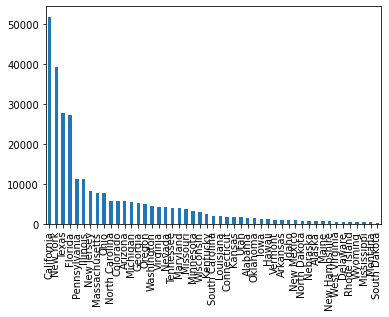

In [13]:
all_tweets.state.value_counts().plot(kind = 'bar')

The same inbalance is visible when looking at tweets per state

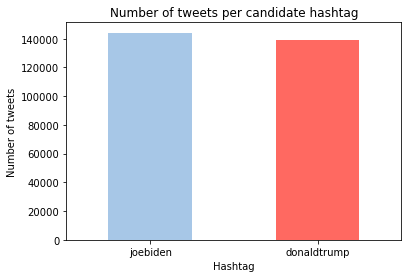

In [14]:
fig = plt.figure()
ax = all_tweets.president_hashtag.value_counts().plot(kind = 'bar',
                                    title="Number of tweets per candidate hashtag",color=['#A7C7E7', '#ff6961'])
ax.set_xlabel("Hashtag")
ax.set_ylabel("Number of tweets")
plt.xticks(rotation=0)

fig.savefig('all_tweets_president_hashtag.jpg', bbox_inches='tight')

In [15]:
all_tweets.president_hashtag.value_counts(normalize=True)

joebiden       0.509333
donaldtrump    0.490667
Name: president_hashtag, dtype: float64

For the two hashtags for both candidates, the data is almost perfectly balanced.

In [16]:
# General descriptives
all_tweets.describe()

,tweet_id,likes,retweet_count,user_followers_count
count,2.831290e+05,283129.000000,283129.000000,2.831290e+05
mean,1.321738e+18,8.937936,2.075284,8.560351e+03
std,2.719115e+15,421.057767,64.347973,8.936253e+04
min,1.316529e+18,0.000000,0.000000,0.000000e+00
25%,1.319455e+18,0.000000,0.000000,1.250000e+02
50%,1.322115e+18,0.000000,0.000000,6.090000e+02
75%,1.324165e+18,1.000000,0.000000,2.494000e+03
max,1.325589e+18,165702.000000,20615.000000,5.750841e+06


Due to the imbalanced data, we will use the 10.000 most liked tweets per 'dominant_party'

In [17]:
# Create new dataframe with 10.000 most liked tweets in each category
most_likes_rep = all_tweets[all_tweets['dominant_party']=='republican'].nlargest(10000, ['likes'])
most_likes_swing = all_tweets[all_tweets['dominant_party']=='swing'].nlargest(10000, ['likes'])
most_likes_dem = all_tweets[all_tweets['dominant_party']=='democrat'].nlargest(10000, ['likes'])
all_tweets_most_likes = pd.concat([most_likes_rep, most_likes_swing, most_likes_dem]).drop_duplicates(["tweet_id"]).reset_index(drop = True)

In [18]:
# Change data type of numerical values
all_tweets_most_likes['tweet_id']=all_tweets_most_likes['tweet_id'].astype('uint32')
all_tweets_most_likes['likes']=all_tweets_most_likes['likes'].astype('uint32')
all_tweets_most_likes['retweet_count']=all_tweets_most_likes['retweet_count'].astype('uint16')
all_tweets_most_likes['user_followers_count']=all_tweets_most_likes['user_followers_count'].astype('uint32')

In [19]:
all_tweets_most_likes[['likes','retweet_count','user_followers_count']].describe().round()

,likes,retweet_count,user_followers_count
count,30000.0,30000.0,30000.0
mean,79.0,18.0,53388.0
std,1291.0,197.0,265827.0
min,1.0,0.0,0.0
25%,4.0,0.0,792.0
50%,9.0,2.0,3467.0
75%,23.0,6.0,16544.0
max,165702.0,20615.0,5750841.0


In [20]:
all_tweets_most_likes.groupby('dominant_party').sum()

,tweet_id,likes,retweet_count,user_followers_count
dominant_party,,,,
democrat,2.160732e+13,1821332.0,382636.0,834233034.0
republican,2.138466e+13,101473.0,27131.0,66831362.0
swing,2.150376e+13,444283.0,131148.0,700569457.0


In [21]:
all_tweets_most_likes.to_csv("most_liked_tweets.csv")